## Landmark Detection

In [1]:
import sys
sys.path.append('./HRNet-Facial-Landmark-Detection')

In [2]:
from lib.models.hrnet import HighResolutionNet
from lib.config import config
from lib.models import get_face_alignment_net
from lib.utils.transforms import crop
import torch
import numpy as np
from PIL import Image
from skimage.transform import resize
from matplotlib import pyplot as plt 
import cv2

In [4]:
config.defrost()
config.merge_from_file("./face_alignment_300w_hrnet_w18.yaml")
config.OUTPUT_DIR = './out'
#config.GPUS = (0 , 1)
config.MODEL.INIT_WEIGHTS = False
config.freeze()
model = get_face_alignment_net(config)
device = torch.device('cpu')
model.to(device)
model = model.cpu()
image_path = './side_crop.png'
state_dict = torch.load("./cpu_model.pth", map_location=device)
model.load_state_dict(torch.load("./cpu_model.pth", map_location=device))

<All keys matched successfully>

In [5]:
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
img = np.array(Image.open(image_path).convert('RGB'), dtype=np.float32)
img = resize(img, [256,256])
img = img.astype(np.float32)
img = (img/255.0 - mean) / std
img = img.transpose([2, 0, 1])

In [6]:
output = model(torch.Tensor(img).unsqueeze(dim=0))

/home/cameron/storage/miniconda3/envs/cameronenv/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


In [16]:
output = output.data.cpu()

In [7]:
def get_preds(scores):
    """
    get predictions from score maps in torch Tensor
    return type: torch.LongTensor
    """
    assert scores.dim() == 4, 'Score maps should be 4-dim'
    maxval, idx = torch.max(scores.view(scores.size(0), scores.size(1), -1), 2)

    maxval = maxval.view(scores.size(0), scores.size(1), 1)
    idx = idx.view(scores.size(0), scores.size(1), 1) + 1

    preds = idx.repeat(1, 1, 2).float()

    preds[:, :, 0] = (preds[:, :, 0] - 1) % scores.size(3) + 1
    preds[:, :, 1] = torch.floor((preds[:, :, 1] - 1) / scores.size(3)) + 1

    pred_mask = maxval.gt(0).repeat(1, 1, 2).float()
    preds *= pred_mask
    return preds

In [9]:
coords = get_preds(output)
coords = coords.squeeze()
coords = coords.numpy()

In [11]:
temple_points = [coords[0], coords[16]]
eye_points = [coords[39], coords[42]]
#Eye and temple points
#(0,16)
#(39,42)

In [18]:
from torchvision import models
import torch
from torchvision.models.segmentation.fcn import FCNHead
import torchvision.transforms as T
from PIL import Image
import os
import numpy as np
device = torch.device('cpu')
fcn_load = models.segmentation.fcn_resnet101(pretrained=False)
fcn_load.classifier = FCNHead(2048,2)
fcn_load.aux_classifier = FCNHead(1024,2)
#state_dict = torch.load("./paper_model", map_location=device)
fcn_load.load_state_dict(torch.load("./paper_model", map_location=device))

base = './paper_dataset/20210307_003056 (2).jpg'
fcn_load.aux_classifier = None
trf_x = T.Compose([T.Resize([256,256]),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
out = trf_x(Image.open(os.path.join(base)).convert('RGB'))
out= out.unsqueeze(0)
out = fcn_load(out.float())['out']
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
om_list = list(om)
for i in range(len(om_list)):
    if 0 in list(om_list[i]):
        top = i
        print(top)
        break
for j in range(len(om_list)):
    if 0 in list(om_list[len(om_list)-1 - j ]):
        print(len(om_list)-1 - j)
        bottom = len(om_list)-1 - j 
        break
distance  = bottom-top
dist_eye = np.linalg.norm(eye_points[0]-eye_points[1])*4
dist_temple =  np.linalg.norm(temple_points[0]-temple_points[1])*4
out_eye = 11.5 * ((dist_eye*0.5)/distance)
out_temple = 11.5 * (dist_temple/distance)

54
226


In [19]:
out_eye

0.5348837209302325

In [20]:
out_temple

9.690846775853357

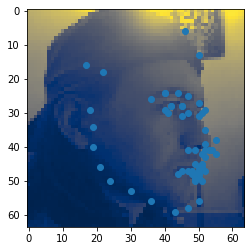

In [20]:
res = cv2.resize(img[2,:,:], dsize=(64, 64), interpolation=cv2.INTER_CUBIC )
plt.imshow(res,cmap="cividis")
plt.scatter(coords[:,0],coords[:,1])

## Paper Segmentation

In [3]:
from torchvision import models
from torchvision.models.segmentation.fcn import FCNHead
import torchvision.transforms as T
fcn = models.segmentation.fcn_resnet101(pretrained=True)
fcn.classifier = FCNHead(2048,2)
fcn.aux_classifier = FCNHead(1024,2)
model_ft = fcn

In [7]:
from torchvision import transforms
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop([256,256]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([256,256]),
        transforms.CenterCrop([256,256]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [4]:
def make_binary(x):
    return 1 if x < 0.5 else 0

In [5]:
import os
base = './paper_dataset'
files = [ file.split('.')[0] for file in os.listdir(base + '/segmentation') if os.path.isdir(base + '/segmentation/' + file) == False]
data = []
trf_y = T.Compose([T.Resize([256,256]),
                 T.ToTensor()])
trf_x = T.Compose([T.Resize([256,256]),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
for file in files:
    y_val = trf_y(Image.open(os.path.join(base+'/segmentation',file+'.png')).convert('L')).squeeze()
    for j in range(y_val.shape[0]):
            for k in range(y_val.shape[1]):
                y_val[j,k] = make_binary(y_val[j,k])    
    data.append({'data' : trf_x(Image.open(os.path.join(base,file+'.jpg')).convert('RGB')) ,'seg' : y_val})

In [16]:
def col_fn (x):
    out_x = []
    out_y = []
    for i in x:
        out_x.append(i['data'])
        out_y.append(i['seg'])        
    return torch.stack(out_x), torch.stack(out_y)

In [17]:
dataloaders = dict()
dataloaders['train'] = torch.utils.data.DataLoader(data,collate_fn = col_fn)

In [ ]:
# Send the model to GPU
device = torch.device("cuda:0")
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [36]:
import copy
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    #since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #print(inputs)
                #print(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)['out']
                        #print(outputs)
                        #print(labels)
                        loss = criterion(outputs, labels.type(torch.LongTensor).cuda())

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
model_out, val_acc_history = train_model(model = model_ft, dataloaders=dataloaders, criterion = criterion, optimizer = optimizer_ft)

In [43]:
import os
base = './paper_dataset/20210307_003056 (2).jpg'
out = trf_x(Image.open(os.path.join(base)).convert('RGB'))
out= out.unsqueeze(0)

In [45]:
out = model_out(out.cuda().float())['out']

In [46]:
out.shape

torch.Size([1, 2, 256, 256])

In [61]:
torch.save(model_out.state_dict(),'./paper_model')

In [19]:
from torchvision import models
import torch
from torchvision.models.segmentation.fcn import FCNHead
import torchvision.transforms as T
from PIL import Image
import os
import numpy as np
device = torch.device('cpu')
fcn_load = models.segmentation.fcn_resnet101(pretrained=False)
fcn_load.classifier = FCNHead(2048,2)
fcn_load.aux_classifier = FCNHead(1024,2)
#state_dict = torch.load("./paper_model", map_location=device)
fcn_load.load_state_dict(torch.load("./paper_model", map_location=device))

base = './paper_dataset/20210307_003056 (2).jpg'
fcn_load.aux_classifier = None
trf_x = T.Compose([T.Resize([256,256]),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
out = trf_x(Image.open(os.path.join(base)).convert('RGB'))
out= out.unsqueeze(0)
out = fcn_load(out.float())['out']
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
om_list = list(om)
for i in range(len(om_list)):
    if 0 in list(om_list[i]):
        top = i
        print(top)
        break
for j in range(len(om_list)):
    if 0 in list(om_list[len(om_list)-1 - j ]):
        print(len(om_list)-1 - j)
        bottom = len(om_list)-1 - j 
        break
distance  = 226-55

55
226


In [ ]:
a =
dist = np.linalg.norm(a-b)

In [47]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()

print (om.shape)

(256, 256)


In [58]:
om_list = list(om)
for i in range(len(om_list)):
    if 0 in list(om_list[i]):
        top = i
        print(top)
        break
for j in range(len(om_list)):
    if 0 in list(om_list[len(om_list)-1 - j ]):
        print(len(om_list)-1 - j)
        bottom = len(om_list)-1 - j 
        break

54
226


In [59]:
distance = 226-54

In [60]:
distance

172

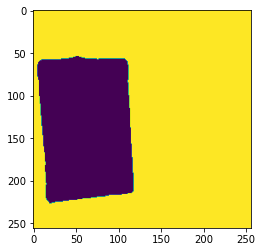

In [50]:
plt.imshow(om)

In [13]:
#Used for converting dict to cpu version we dont need this cell 
from collections import OrderedDict
state_dict = torch.load("./cpu_model")
new_state_dict = OrderedDict()

for key, value in state_dict.items():
    new_key = key.replace('module.','')
    new_state_dict[new_key] = value

torch.save(new_state_dict, './cpu_model')